In [12]:
!pip install -i https://test.pypi.org/simple/ RobustGibbs-AntoineLuciano

Looking in indexes: https://test.pypi.org/simple/
  Using cached https://test-files.pythonhosted.org/packages/a6/7c/f6657840da63653b48253b34293fe8b8d03dc5ad1fdf4b6ab7fd39a295e9/robustgibbs_antoineluciano-0.0.1-py3-none-any.whl (17 kB)


In [5]:
from MAD import *
from tqdm import tqdm
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [6]:
def post_NIG(X, par_prior_loc, par_prior_scale,size):
    mu_0, nu = par_prior_loc
    alpha, beta = par_prior_scale
    n = len(X)
    tau = np.random.gamma(
        shape=alpha + n / 2,
        scale=1
        / (
            beta
            + np.sum((X - np.mean(X)) ** 2) / 2
            + n * nu * (np.mean(X) - mu_0) ** 2 / (2 * (nu + n))
        ),
        size=size,
    )
    mu = np.random.normal(
        loc=(nu * mu_0 + np.sum(X)) / (nu + n),
        scale=1 / np.sqrt((nu + n) * tau),
        size=size,
    )
    return [mu, 1 / (tau)]

In [8]:
T = 100000
N = 1000


mu,sigma=-2,4
Z=np.random.normal(mu,sigma,N)

X_0=np.round(np.random.normal(mu,sigma,N),8)

med_X,MAD_X=medMAD(X_0)

par_prior_loc,par_prior_scale=[0,1],[1,1]

Normal_MAD = Gibbs_med_MAD(T,N,med_X,MAD_X,"normal",prior_loc="NIG",par_prior_loc=par_prior_loc,par_prior_scale=par_prior_scale)
#Normal_X=post_NIG(X_0,par_prior_loc,par_prior_scale,T)

100%|██████████| 100000/100000 [01:04<00:00, 1543.34it/s]


Text(0, 0.5, '')

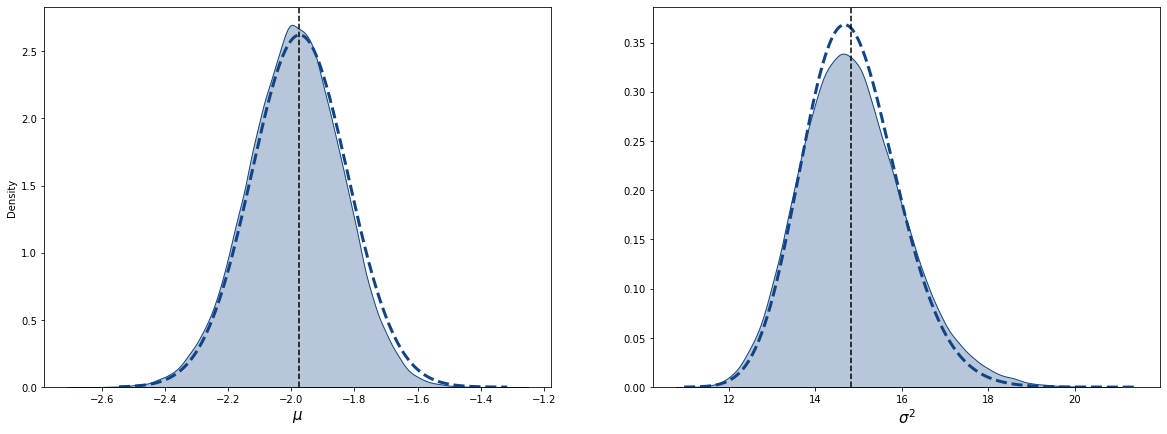

In [10]:
import numpy as np
from scipy.stats import t,invgamma
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(20,7))

dico_MAD = Normal_MAD
mu_0,nu = dico_MAD["par_prior_loc"]
alpha,beta=dico_MAD["par_prior_scale"]
mu_chain,sigma2_chain = dico_MAD["chains"]["loc"],dico_MAD["chains"]["scale"]**2
N=len(dico_MAD["X"][0])
med,MAD=medMAD(dico_MAD["X"][0])

c=1/scipy.stats.norm.ppf(0.75,loc=0,scale=1)
S2= (c*MAD)**2

N_mean,N_var=N * 2/np.math.pi,N*0.3674

alpha_MAD = alpha + N_var / 2
beta_MAD = beta+ (N_var * S2+ N_mean * nu * (med - mu_0) ** 2 / (nu + N_mean))/ 2
mu_MAD = (nu * mu_0 + N_mean * med) / (nu + N_mean)
nu_MAD = nu + N_mean 
loc_MAD=mu_MAD
scale_MAD=np.sqrt(beta_MAD/(alpha_MAD*nu_MAD))
df_MAD=2*alpha_MAD

sns.kdeplot(mu_chain,ax=ax[0],label="Robust Gibbs",fill=True,alpha=.3,color="#114484")
ax[0].set_xlabel("$\mu$",fontsize=15)

sns.kdeplot(sigma2_chain,ax=ax[1],label="Robust Gibbs",fill=True,alpha=.3,color='#114484')



x = np.linspace(t.ppf(0.0001, df_MAD, loc=loc_MAD, scale=scale_MAD),
                t.ppf(0.99999, df_MAD, loc=loc_MAD, scale=scale_MAD), 1000)

ax[0].plot(x, t.pdf(x, df_MAD, loc=loc_MAD, scale=scale_MAD), '--', label='Approximation pdf (Student)',lw=3,color="#114484")

x = np.linspace(invgamma.ppf(0.00001, alpha_MAD, scale=beta_MAD),
                invgamma.ppf(0.999999, alpha_MAD, scale=beta_MAD), 1000)

ax[1].plot(x,invgamma.pdf(x, alpha_MAD, scale=beta_MAD),'--', label='Approximation pdf (InvGamma)',lw=3,color="#114484")

ax[0].axvline(x=med_X,linestyle="--",color="black",label="True $\mu$ value")

ax[1].axvline(x=(MAD_X*c)**2,linestyle="--",color="black",label="True $\sigma^2$ value")


ax[1].set_xlabel("$\sigma^2$",fontsize=15)
ax[1].set_ylabel("",fontsize=1)
